Cricket Win Prediction System

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

Importing Datasets

In [75]:
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

Data Preprocessing

In [76]:
total_score_df = delivery.groupby(['match_id','inning']).sum()['total_runs']
total_score_df = total_score_df.reset_index()
total_score_df  = total_score_df[total_score_df["inning"]==1]

In [77]:
total_score_df

,match_id,inning,total_runs
0,335982,1,222
2,335983,1,240
4,335984,1,129
6,335985,1,165
8,335986,1,110
...,...,...,...
2065,1359544,1,197
2067,1370350,1,172
2069,1370351,1,182
2071,1370352,1,233


In [78]:
#now combing the runs scored in 1st innings to match data
match_df = match.merge(total_score_df[['match_id','total_runs']] , left_on='id' , right_on='match_id')

In [79]:
#selecting and removing old teams
teams = [
    'Royal Challengers Bangalore','Punjab Kings',
    'Mumbai Indians','Chennai Super Kings',
    'Kolkata Knight Riders','Sunrisers Hyderabad',
    'Rajasthan Royals','Lucknow Super Giants',
    'Delhi Capitals','Gujarat Titans'
]

match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['team1'] = match_df['team1'].str.replace('Kings XI Punjab','Punjab Kings')
match_df['team2'] = match_df['team2'].str.replace('Kings XI Punjab','Punjab Kings')

match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

match_df['team1'] = match_df['team1'].str.replace('Gujarat Lions','Gujarat Titans')
match_df['team2'] = match_df['team2'].str.replace('Gujarat Lions','Gujarat Titans')

In [80]:
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]
updated_df = match_df

In [81]:
match_df = match_df[['match_id','city','winner','total_runs']]
delivery_df = match_df.merge(delivery,on='match_id')

In [82]:
##for ist ans 2nd innings
delivery_df1 = delivery_df[delivery_df['inning']==1]
delivery_df2 = delivery_df[delivery_df['inning']==2]
delivery_df1

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,Bangalore,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,Bangalore,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,Bangalore,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,Bangalore,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,Bangalore,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222845,1370353,Ahmedabad,Chennai Super Kings,214,1,Gujarat Titans,Chennai Super Kings,19,2,B Sai Sudharsan,M Pathirana,HH Pandya,6,0,6,NaN,0,NaN,NaN,NaN
222846,1370353,Ahmedabad,Chennai Super Kings,214,1,Gujarat Titans,Chennai Super Kings,19,3,B Sai Sudharsan,M Pathirana,HH Pandya,0,0,0,NaN,1,B Sai Sudharsan,lbw,NaN
222847,1370353,Ahmedabad,Chennai Super Kings,214,1,Gujarat Titans,Chennai Super Kings,19,4,Rashid Khan,M Pathirana,HH Pandya,0,1,1,byes,0,NaN,NaN,NaN
222848,1370353,Ahmedabad,Chennai Super Kings,214,1,Gujarat Titans,Chennai Super Kings,19,5,HH Pandya,M Pathirana,Rashid Khan,0,1,1,legbyes,0,NaN,NaN,NaN


In [83]:
delivery_df1.loc[:, 'curr_score'] = delivery_df1.groupby('match_id')['total_runs_y'].cumsum()
delivery_df2.loc[:, 'curr_score'] = delivery_df2.groupby('match_id')['total_runs_y'].cumsum()

delivery_df2.loc[:, 'runs_left']  =  delivery_df2['total_runs_x'] - delivery_df2['curr_score']
delivery_df1.loc[:,'balls_left'] = 120 - (delivery_df1['over'] * 6 + delivery_df1['ball'])
delivery_df2.loc[:,'balls_left'] = 120 - (delivery_df2['over'] * 6 + delivery_df2['ball'])


In [84]:
delivery_df1['player_dismissed'] = delivery_df1['player_dismissed'].fillna("0")
delivery_df1['player_dismissed'] = delivery_df1['player_dismissed'].apply(lambda x:x if x == "0" else "1")
delivery_df1['player_dismissed'] = delivery_df1['player_dismissed'].astype('int')
wickets = delivery_df1.groupby('match_id')['player_dismissed'].cumsum().values
delivery_df1['wickets'] = 10 - wickets

delivery_df2['player_dismissed'] = delivery_df2['player_dismissed'].fillna("0")
delivery_df2['player_dismissed'] = delivery_df2['player_dismissed'].apply(lambda x:x if x == "0" else "1")
delivery_df2['player_dismissed'] = delivery_df2['player_dismissed'].astype('int')
wickets = delivery_df2.groupby('match_id')['player_dismissed'].cumsum().values
delivery_df2['wickets'] = 10 - wickets

In [85]:
##current_run_rate = runs/over
delivery_df1.loc[:,'current_rr'] = (delivery_df1['curr_score'] * 6)/(120-delivery_df1['balls_left'])
delivery_df2.loc[:,'current_rr'] = (delivery_df2['curr_score'] * 6)/(120-delivery_df2['balls_left'])

delivery_df2.loc[:,'required_rr'] = (delivery_df2['runs_left']*6)/delivery_df2['balls_left']

In [86]:
def result(row):
    return 1 if row['batting_team']==row['winner'] else 0

In [87]:
delivery_df1.loc[:,'result']  = delivery_df1.apply(result,axis=1)
delivery_df2.loc[:,'result']  = delivery_df2.apply(result,axis=1)
delivery_df1.rename(columns={"wickets":"wickets_left"},inplace=True)
delivery_df2.rename(columns={"wickets":"wickets_left"},inplace=True)

In [88]:
final_df1 = delivery_df1[['match_id','batting_team','bowling_team','city','balls_left','wickets_left','curr_score',
                        'current_rr','result']]
final_df2 = delivery_df2[['match_id','batting_team','bowling_team','city','runs_left','balls_left','wickets_left','total_runs_x',
                        'current_rr','required_rr','result']]

In [89]:
final_df1

,match_id,batting_team,bowling_team,city,balls_left,wickets_left,curr_score,current_rr,result
0,335982,Kolkata Knight Riders,Royal Challengers Bangalore,Bangalore,119,10,1,6.000000,1
1,335982,Kolkata Knight Riders,Royal Challengers Bangalore,Bangalore,118,10,1,3.000000,1
2,335982,Kolkata Knight Riders,Royal Challengers Bangalore,Bangalore,117,10,2,4.000000,1
3,335982,Kolkata Knight Riders,Royal Challengers Bangalore,Bangalore,116,10,2,3.000000,1
4,335982,Kolkata Knight Riders,Royal Challengers Bangalore,Bangalore,115,10,2,2.400000,1
...,...,...,...,...,...,...,...,...,...
222845,1370353,Gujarat Titans,Chennai Super Kings,Ahmedabad,4,8,212,10.965517,0
222846,1370353,Gujarat Titans,Chennai Super Kings,Ahmedabad,3,7,212,10.871795,0
222847,1370353,Gujarat Titans,Chennai Super Kings,Ahmedabad,2,7,213,10.830508,0
222848,1370353,Gujarat Titans,Chennai Super Kings,Ahmedabad,1,7,214,10.789916,0


In [90]:
final_df2

,match_id,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,total_runs_x,current_rr,required_rr,result
124,335982,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,221,119,10,222,6.000000,11.142857,0
125,335982,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,220,118,10,222,6.000000,11.186441,0
126,335982,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,220,117,10,222,4.000000,11.282051,0
127,335982,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,219,116,10,222,4.500000,11.327586,0
128,335982,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,218,115,10,222,4.800000,11.373913,0
...,...,...,...,...,...,...,...,...,...,...,...
222939,1370353,Chennai Super Kings,Gujarat Titans,Ahmedabad,55,34,5,214,11.093023,9.705882,1
222940,1370353,Chennai Super Kings,Gujarat Titans,Ahmedabad,54,33,5,214,11.034483,9.818182,1
222941,1370353,Chennai Super Kings,Gujarat Titans,Ahmedabad,53,32,5,214,10.977273,9.937500,1
222942,1370353,Chennai Super Kings,Gujarat Titans,Ahmedabad,47,31,5,214,11.258427,9.096774,1


In [91]:
final_df1 = final_df1.sample(final_df1.shape[0])
final_df1.dropna(inplace = True)
final_df1 = final_df1[final_df1['balls_left'] != 0]

final_df2 = final_df2.sample(final_df2.shape[0])
final_df2.dropna(inplace = True)
final_df2 = final_df2[final_df2['balls_left'] != 0]

Machine learning models

In [92]:
trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

In [93]:
pipe1 = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

pipe2 = Pipeline(steps=[
    ('step1',trf),
    ('step2',RandomForestClassifier())
])

# K-Nearest Neighbors Pipeline
pipe3 = Pipeline(steps=[
    ('step1', trf),
    ('step2', KNeighborsClassifier())
])

# Decision Tree Pipeline
pipe4 = Pipeline(steps=[
    ('step1', trf),
    ('step2', DecisionTreeClassifier())
])


In [94]:
X = final_df1.iloc[:,:-1]
y = final_df1.iloc[:,-1]
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=1)

Logistic Regression for Ist Innings

In [95]:
pipe1.fit(X_train,y_train)
y_pred = pipe1.predict(X_test)
accuracy_score1  = accuracy_score(y_test,y_pred)
precision1 = precision_score(y_test, y_pred, average='binary')
recall1 = recall_score(y_test, y_pred, average='binary') 
f11 = f1_score(y_test, y_pred, average='binary')
conf_matrix1 = confusion_matrix(y_test, y_pred)
print("Accuracy score :",accuracy_score1)
print("Precision score : ", precision1)
print("Recall score:", recall1)
print("F1 score:", f11)
print("Confusion Matrix:\n", conf_matrix1)

Accuracy score : 0.5561054579093432
Precision score :  0.5365089313694766
Recall score: 0.17416073245167854
F1 score: 0.2629598341141234
Confusion Matrix:
 [[10311  1479]
 [ 8118  1712]]


Random Forest Classifier for Ist Innings

In [96]:
pipe2.fit(X_train,y_train)
y_pred = pipe2.predict(X_test)
accuracy_score2  = accuracy_score(y_test,y_pred)
precision2 = precision_score(y_test, y_pred, average='binary')
recall2 = recall_score(y_test, y_pred, average='binary') 
f12 = f1_score(y_test, y_pred, average='binary')
conf_matrix2 = confusion_matrix(y_test, y_pred)
print("Accuracy score :",accuracy_score2)
print("Precision score : ", precision2)
print("Recall score:", recall2)
print("F1 score:", f12)
print("Confusion Matrix:\n", conf_matrix2)

Accuracy score : 0.997872340425532
Precision score :  0.9979641693811075
Recall score: 0.9973550356052899
F1 score: 0.9976595095146027
Confusion Matrix:
 [[11770    20]
 [   26  9804]]


In [97]:
pipe3.fit(X_train,y_train)
y_pred = pipe3.predict(X_test)
accuracy_score3  = accuracy_score(y_test,y_pred)
precision3 = precision_score(y_test, y_pred, average='binary')
recall3 = recall_score(y_test, y_pred, average='binary') 
f13 = f1_score(y_test, y_pred, average='binary')
conf_matrix3 = confusion_matrix(y_test, y_pred)
print("Accuracy score :",accuracy_score3)
print("Precision score : ", precision3)
print("Recall score:", recall3)
print("F1 score:", f13)
print("Confusion Matrix:\n", conf_matrix3)

Accuracy score : 0.9169750231267345
Precision score :  0.9164507100653053
Recall score: 0.8993896236012208
F1 score: 0.9078400164296351
Confusion Matrix:
 [[10984   806]
 [  989  8841]]


In [98]:
pipe4.fit(X_train,y_train)
y_pred = pipe4.predict(X_test)
accuracy_score4  = accuracy_score(y_test,y_pred)
precision4 = precision_score(y_test, y_pred, average='binary')
recall4 = recall_score(y_test, y_pred, average='binary') 
f14 = f1_score(y_test, y_pred, average='binary')
conf_matrix4 = confusion_matrix(y_test, y_pred)
print("Accuracy score :",accuracy_score4)
print("Precision score : ", precision4)
print("Recall score:", recall4)
print("F1 score:", f14)
print("Confusion Matrix:\n", conf_matrix4)

Accuracy score : 0.9936170212765958
Precision score :  0.9917799878222042
Recall score: 0.9942014242115972
F1 score: 0.992989229831335
Confusion Matrix:
 [[11709    81]
 [   57  9773]]


Logistic Regression for 2nd Innings

In [99]:
X = final_df2.iloc[:,:-1]
y = final_df2.iloc[:,-1]
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [100]:
pipe1.fit(X_train,y_train)
y_pred = pipe1.predict(X_test)
accuracy_score1  = accuracy_score(y_test,y_pred)
precision1 = precision_score(y_test, y_pred, average='binary')
recall1 = recall_score(y_test, y_pred, average='binary') 
f11 = f1_score(y_test, y_pred, average='binary')
conf_matrix1 = confusion_matrix(y_test, y_pred)
print("Accuracy score :",accuracy_score1)
print("Precision score : ", precision1)
print("Recall score:", recall1)
print("F1 score:", f11)
print("Confusion Matrix:\n", conf_matrix1)

Accuracy score : 0.7629614985419859
Precision score :  0.760960800071435
Recall score: 0.8008645803965793
F1 score: 0.7804029304029304
Confusion Matrix:
 [[6915 2677]
 [2119 8522]]


Random Forest for 2nd Innings

In [101]:
pipe2.fit(X_train,y_train)
y_pred = pipe2.predict(X_test)
accuracy_score2  = accuracy_score(y_test,y_pred)
precision2 = precision_score(y_test, y_pred, average='binary')
recall2 = recall_score(y_test, y_pred, average='binary') 
f12 = f1_score(y_test, y_pred, average='binary')
conf_matrix2 = confusion_matrix(y_test, y_pred)
print("Accuracy score :",accuracy_score2)
print("Precision score : ", precision2)
print("Recall score:", recall2)
print("F1 score:", f12)
print("Confusion Matrix:\n", conf_matrix2)

Accuracy score : 0.9994563337122523
Precision score :  0.9995300751879699
Recall score: 0.9994361432196223
F1 score: 0.9994831069968515
Confusion Matrix:
 [[ 9587     5]
 [    6 10635]]


In [102]:
pipe3.fit(X_train,y_train)
y_pred = pipe3.predict(X_test)
accuracy_score3  = accuracy_score(y_test,y_pred)
precision3 = precision_score(y_test, y_pred, average='binary')
recall3 = recall_score(y_test, y_pred, average='binary') 
f13 = f1_score(y_test, y_pred, average='binary')
conf_matrix3 = confusion_matrix(y_test, y_pred)
print("Accuracy score :",accuracy_score3)
print("Precision score : ", precision3)
print("Recall score:", recall3)
print("F1 score:", f13)
print("Confusion Matrix:\n", conf_matrix3)

Accuracy score : 0.9892749468689764
Precision score :  0.9904027098231087
Recall score: 0.9891927450427591
F1 score: 0.9897973576566834
Confusion Matrix:
 [[ 9490   102]
 [  115 10526]]


In [103]:
pipe4.fit(X_train,y_train)
y_pred = pipe4.predict(X_test)
accuracy_score4  = accuracy_score(y_test,y_pred)
precision4 = precision_score(y_test, y_pred, average='binary')
recall4 = recall_score(y_test, y_pred, average='binary') 
f14 = f1_score(y_test, y_pred, average='binary')
conf_matrix4 = confusion_matrix(y_test, y_pred)
print("Accuracy score :",accuracy_score4)
print("Precision score : ", precision4)
print("Recall score:", recall4)
print("F1 score:", f14)
print("Confusion Matrix:\n", conf_matrix4)

Accuracy score : 0.993377156131073
Precision score :  0.993610824015785
Recall score: 0.9937975754158443
F1 score: 0.9937041909415523
Confusion Matrix:
 [[ 9524    68]
 [   66 10575]]


Accuracy Comparison

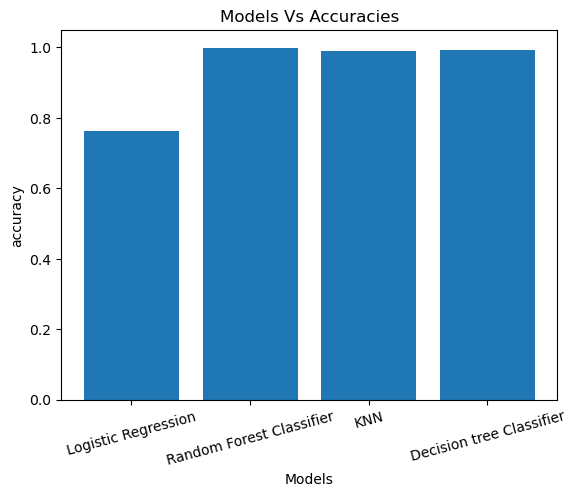

In [112]:
models = ['Logistic Regression' , 'Random Forest Classifier','KNN','Decision tree Classifier']
accuracies = [accuracy_score1,accuracy_score2,accuracy_score3,accuracy_score4]
plt.bar(models,accuracies)
plt.title("Models Vs Accuracies")
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.xticks(rotation=15)
plt.show()

Removing Rain Affected matches and Comparing Accuracies

In [113]:
updated_df[updated_df['method']=='D/L'].count()

id                 17
season             17
city               17
date               17
match_type         17
player_of_match    17
venue              17
team1              17
team2              17
toss_winner        17
toss_decision      17
winner             17
result             17
result_margin      17
target_runs        17
target_overs       17
super_over         17
method             17
umpire1            17
umpire2            17
match_id           17
total_runs         17
dtype: int64

In [114]:
new_df = updated_df[updated_df['method']!='D/L']
new_df = new_df[['match_id','city','winner','total_runs']]
new_df = new_df.merge(delivery,on='match_id')
new_df = new_df[new_df['inning']==2]
new_df.loc[:,'curr_score'] = new_df.groupby('match_id')['total_runs_y'].cumsum()
new_df.loc[:, 'runs_left']  =  new_df['total_runs_x'] - new_df['curr_score']
new_df.loc[:,'balls_left'] = 120 - (new_df['over'] * 6 + new_df['ball'])
new_df['player_dismissed'] = new_df['player_dismissed'].fillna("0")
new_df['player_dismissed'] = new_df['player_dismissed'].apply(lambda x:x if x == "0" else "1")
new_df['player_dismissed'] = new_df['player_dismissed'].astype('int')
wickets = new_df.groupby('match_id')['player_dismissed'].cumsum().values
new_df['wickets'] = 10 - wickets


In [115]:
##current_run_rate = runs/over
new_df.loc[:,'current_rr'] = (new_df['curr_score'] * 6)/(120-new_df['balls_left'])
new_df.loc[:,'required_rr'] = (new_df['runs_left']*6)/new_df['balls_left']
new_df.loc[:,'result']  = new_df.apply(result,axis=1)
new_df.rename(columns={"wickets":"wickets_left"},inplace=True)
final_df3 = new_df[['match_id','batting_team','bowling_team','city','runs_left','balls_left','wickets_left','total_runs_x',
                        'current_rr','required_rr','result']]

In [116]:
final_df3.dropna(inplace = True)
final_df3 = final_df3[final_df3['balls_left'] != 0]
X = final_df3.iloc[:,:-1]
y = final_df3.iloc[:,-1]
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [117]:
pipe1.fit(X_train,y_train)
y_pred = pipe1.predict(X_test)
accuracy_score3  = accuracy_score(y_test,y_pred)
precision3 = precision_score(y_test, y_pred, average='binary')
recall3 = recall_score(y_test, y_pred, average='binary') 
f13 = f1_score(y_test, y_pred, average='binary')
conf_matrix3 = confusion_matrix(y_test, y_pred)
print("Accuracy score :",accuracy_score3)
print("Precision score : ", precision3)
print("Recall score:", recall3)
print("F1 score:", f13)
print("Confusion Matrix:\n", conf_matrix3)

Accuracy score : 0.7653876898481216
Precision score :  0.7645778543574862
Recall score: 0.8005887380115848
F1 score: 0.7821690323777716
Confusion Matrix:
 [[6889 2596]
 [2100 8431]]


Comapring accuracies of dataset with and without rain affected matches with logistic Regression

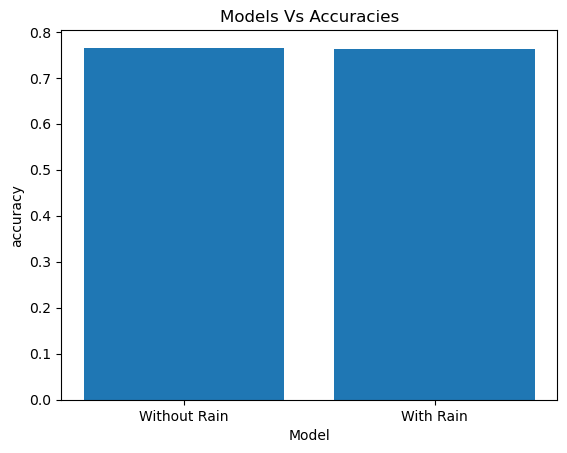

In [118]:
models = ['Without Rain' , 'With Rain']
accuracies = [accuracy_score3,accuracy_score1]
plt.bar(models,accuracies)
plt.title("Models Vs Accuracies")
plt.xlabel('Model')
plt.ylabel('accuracy')
plt.show()

Comparison by Filtering Final Scores

In [119]:
filter1, filter2 = 0, 120
filter3, filter4 = 120, 150
filter5, filter6 = 150, 175
filter7, filter8 = 175, 200
filter9 =  200
df1 = final_df2[(final_df2['total_runs_x'] >= filter1) & (final_df2['total_runs_x'] < filter2)]
df1 = df1.drop_duplicates()
df2 = final_df2[(final_df2['total_runs_x'] >= filter3) & (final_df2['total_runs_x'] < filter4)]
df2 = df2.drop_duplicates()
df3 = final_df2[(final_df2['total_runs_x'] >= filter5) & (final_df2['total_runs_x'] < filter6)]
df3 = df3.drop_duplicates()
df4 = final_df2[(final_df2['total_runs_x'] >= filter7) & (final_df2['total_runs_x'] < filter8)]
df4 = df4.drop_duplicates()
df5 = final_df2[(final_df2['total_runs_x'] >= filter9)]
df5 = df5.drop_duplicates()

In [120]:
def find_accuracy(data):
    X = final_df2.iloc[:,:-1]
    y = final_df2.iloc[:,-1]
    X_train , X_test , y_train, y_test = train_test_split(X,y,test_size=0.2)
    pipe1.fit(X_train,y_train)
    y_pred = pipe1.predict(X_test)
    accuracy  = accuracy_score(y_test,y_pred)
    return accuracy

In [121]:
dfs = [df1 , df2 , df3 , df4 , df5]
accuracy_final = []
for data in dfs:
    accuracy = find_accuracy(data)
    accuracy_final.append(accuracy)

In [122]:
accuracy_final

[0.7681510403795779,
 0.7651855879009539,
 0.7681510403795779,
 0.764493648989275,
 0.7687935550832798]

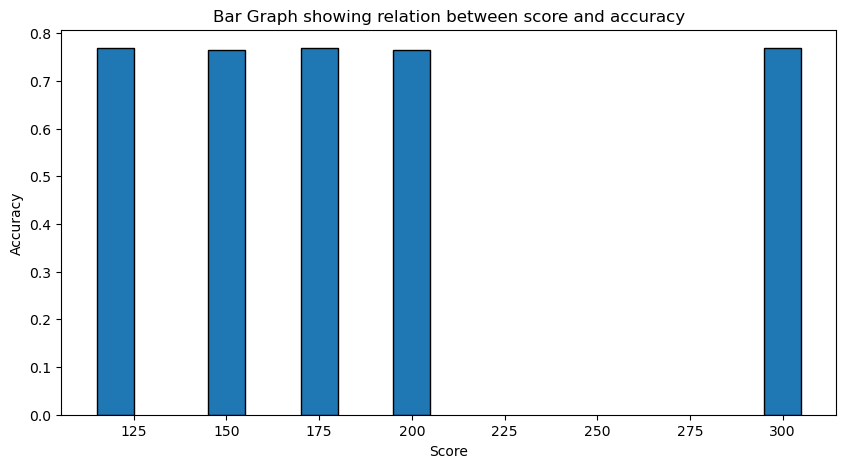

In [123]:
upper_limit = [120,150,175,200,300]
plt.figure(figsize=(10,5))
plt.bar(upper_limit,accuracy_final,width=10,edgecolor='black')
plt.title('Bar Graph showing relation between score and accuracy')
plt.xlabel('Score')
plt.ylabel('Accuracy')
plt.show()

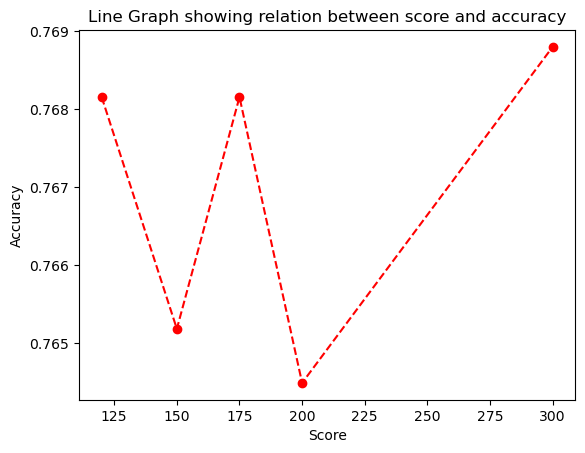

In [124]:
plt.plot(upper_limit, accuracy_final, marker='o', linestyle='--', color='red')
plt.title('Line Graph showing relation between score and accuracy')
plt.xlabel('Score')
plt.ylabel('Accuracy')
plt.show()

In [125]:
size1=len(set(final_df2[(final_df2['total_runs_x'] >= 0) & (final_df2['total_runs_x'] < 120)]['match_id'].tolist()))
size2=len(set(final_df2[(final_df2['total_runs_x'] >= 120) & (final_df2['total_runs_x'] < 150)]['match_id'].tolist()))
size3=len(set(final_df2[(final_df2['total_runs_x'] >= 150) & (final_df2['total_runs_x'] < 175)]['match_id'].tolist()))
size4=len(set(final_df2[(final_df2['total_runs_x'] >= 175) & (final_df2['total_runs_x'] < 200)]['match_id'].tolist()))
size5=len(set(final_df2[(final_df2['total_runs_x'] >= 200) & (final_df2['total_runs_x'] < 250)]['match_id'].tolist()))
innings = [size1, size2, size3, size4, size5]
innings

[63, 197, 289, 224, 108]

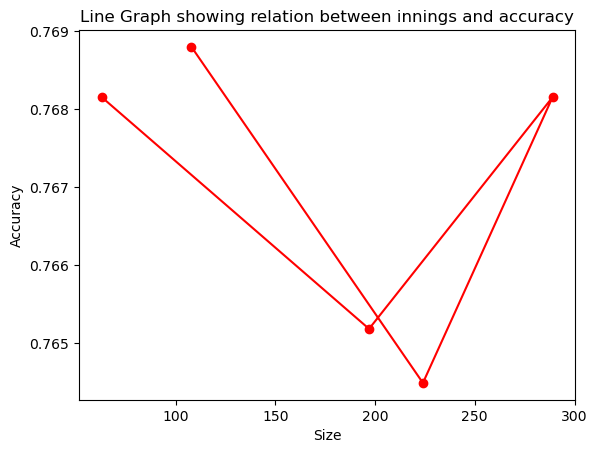

In [126]:
plt.plot(innings, accuracy_final, marker='o', linestyle='-', color='red')
plt.title('Line Graph showing relation between innings and accuracy')
plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.show()

In [127]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['match_id','batting_team','bowling_team','city','runs_left','balls_left','wickets_left','total_runs_x','current_rr','required_rr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target
    

Prediction 

In [128]:
temp_df,target = match_progression(delivery_df2,335985,pipe1)
temp_df

Target- 165


,end_of_over,runs_after_over,wickets_in_over,lose,win
820,1,10,0,39.3,60.7
826,2,1,0,51.5,48.5
832,3,11,0,45.7,54.3
838,4,5,0,50.1,49.9
844,5,10,0,46.3,53.7
851,6,3,1,55.1,44.9
857,7,6,0,57.8,42.2
863,8,8,0,57.4,42.6
869,9,14,1,48.5,51.5
876,10,8,1,49.2,50.8


In [129]:
delivery_df2[delivery_df2['match_id']==335985]

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,...,player_dismissed,dismissal_kind,fielder,curr_score,runs_left,balls_left,wickets_left,current_rr,required_rr,result
815,335985,Mumbai,Royal Challengers Bangalore,165,2,Royal Challengers Bangalore,Mumbai Indians,0,1,S Chanderpaul,...,0,NaN,NaN,0,165,119,10,0.000000,8.319328,1
816,335985,Mumbai,Royal Challengers Bangalore,165,2,Royal Challengers Bangalore,Mumbai Indians,0,2,S Chanderpaul,...,0,NaN,NaN,1,164,118,10,3.000000,8.338983,1
817,335985,Mumbai,Royal Challengers Bangalore,165,2,Royal Challengers Bangalore,Mumbai Indians,0,3,R Dravid,...,0,NaN,NaN,1,164,117,10,2.000000,8.410256,1
818,335985,Mumbai,Royal Challengers Bangalore,165,2,Royal Challengers Bangalore,Mumbai Indians,0,4,R Dravid,...,0,NaN,NaN,2,163,116,10,3.000000,8.431034,1
819,335985,Mumbai,Royal Challengers Bangalore,165,2,Royal Challengers Bangalore,Mumbai Indians,0,5,S Chanderpaul,...,0,NaN,NaN,6,159,115,10,7.200000,8.295652,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,335985,Mumbai,Royal Challengers Bangalore,165,2,Royal Challengers Bangalore,Mumbai Indians,19,1,MV Boucher,...,0,NaN,NaN,164,1,5,5,8.556522,1.200000,1
934,335985,Mumbai,Royal Challengers Bangalore,165,2,Royal Challengers Bangalore,Mumbai Indians,19,2,B Akhil,...,0,NaN,NaN,165,0,4,5,8.534483,0.000000,1
935,335985,Mumbai,Royal Challengers Bangalore,165,2,Royal Challengers Bangalore,Mumbai Indians,19,3,B Akhil,...,0,NaN,NaN,165,0,3,5,8.461538,0.000000,1
936,335985,Mumbai,Royal Challengers Bangalore,165,2,Royal Challengers Bangalore,Mumbai Indians,19,4,B Akhil,...,0,NaN,NaN,165,0,2,5,8.389831,0.000000,1


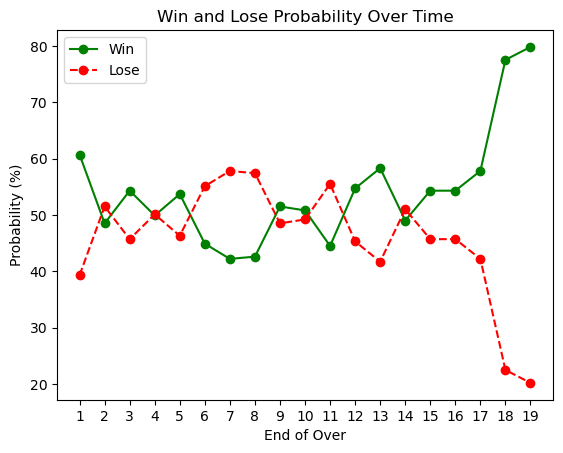

In [130]:
plt.plot(temp_df['end_of_over'],temp_df['win'],color='green',marker='o',linestyle='-')
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',marker='o',linestyle='--')
x_ticks = temp_df['end_of_over'].astype(int)
plt.xticks(x_ticks)

plt.xlabel('End of Over')
plt.ylabel('Probability (%)')
plt.title('Win and Lose Probability Over Time')
plt.legend(['Win', 'Lose'])

plt.show()

In [131]:
temp_df1,target1 = match_progression(delivery_df2,335983,pipe1)
temp_df1

Target- 240


,end_of_over,runs_after_over,wickets_in_over,lose,win
354,1,9,0,98.1,1.9
360,2,7,0,98.2,1.8
366,3,11,0,97.8,2.2
372,4,10,0,97.5,2.5
378,5,10,0,97.2,2.8
384,6,9,1,97.1,2.9
392,7,13,0,96.1,3.9
398,8,15,0,94.0,6.0
404,9,12,0,92.4,7.6
411,10,14,0,89.3,10.7


In [132]:
delivery_df2[delivery_df2['match_id']==335983]

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,...,player_dismissed,dismissal_kind,fielder,curr_score,runs_left,balls_left,wickets_left,current_rr,required_rr,result
349,335983,Chandigarh,Chennai Super Kings,240,2,Kings XI Punjab,Chennai Super Kings,0,1,K Goel,...,0,NaN,NaN,4,236,119,10,24.000000,11.899160,0
350,335983,Chandigarh,Chennai Super Kings,240,2,Kings XI Punjab,Chennai Super Kings,0,2,K Goel,...,0,NaN,NaN,4,236,118,10,12.000000,12.000000,0
351,335983,Chandigarh,Chennai Super Kings,240,2,Kings XI Punjab,Chennai Super Kings,0,3,K Goel,...,0,NaN,NaN,4,236,117,10,8.000000,12.102564,0
352,335983,Chandigarh,Chennai Super Kings,240,2,Kings XI Punjab,Chennai Super Kings,0,4,K Goel,...,0,NaN,NaN,5,235,116,10,7.500000,12.155172,0
353,335983,Chandigarh,Chennai Super Kings,240,2,Kings XI Punjab,Chennai Super Kings,0,5,JR Hopes,...,0,NaN,NaN,5,235,115,10,6.000000,12.260870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,335983,Chandigarh,Chennai Super Kings,240,2,Kings XI Punjab,Chennai Super Kings,19,2,IK Pathan,...,0,NaN,NaN,200,40,4,6,10.344828,60.000000,0
469,335983,Chandigarh,Chennai Super Kings,240,2,Kings XI Punjab,Chennai Super Kings,19,3,SM Katich,...,0,NaN,NaN,200,40,3,6,10.256410,80.000000,0
470,335983,Chandigarh,Chennai Super Kings,240,2,Kings XI Punjab,Chennai Super Kings,19,4,SM Katich,...,0,NaN,NaN,206,34,2,6,10.474576,102.000000,0
471,335983,Chandigarh,Chennai Super Kings,240,2,Kings XI Punjab,Chennai Super Kings,19,5,SM Katich,...,0,NaN,NaN,207,33,1,6,10.436975,198.000000,0


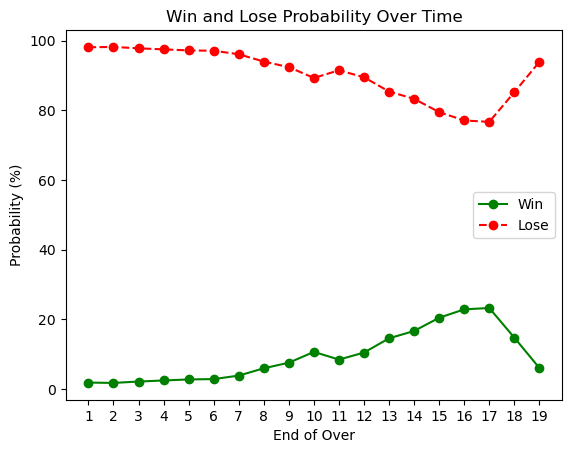

In [133]:
plt.plot(temp_df1['end_of_over'],temp_df1['win'],color='green',marker='o',linestyle='-')
plt.plot(temp_df1['end_of_over'],temp_df1['lose'],color='red',marker='o',linestyle='--')
x_ticks = temp_df['end_of_over'].astype(int)
plt.xticks(x_ticks)

plt.xlabel('End of Over')
plt.ylabel('Probability (%)')
plt.title('Win and Lose Probability Over Time')
plt.legend(['Win', 'Lose'])

plt.show()

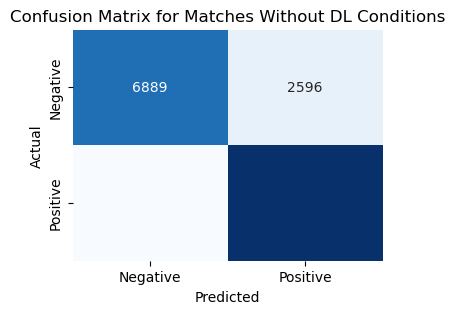

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Provided confusion matrix data
confusion_matrix_data = [[6889, 2596], [2100, 8431]]

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Matches Without DL Conditions')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.show()